# Playing With Variational Autoencoders

## 1. Introduction
Variational autoencoders are a relatively recent deep learning architecture that extends variational Bayesian methods to the deep learning paradigm. In essence, the goal of variational methods is to be able to sample from an otherwise intractable distribution (usually some kind of posterior) by finding a set of parameters that maps this intractable distribution to something simpler that we *can* sample from (or likewise, mapping a simpler distribution onto a mode of the more complex distribution, similar to what is done in the EM algorithm for GMMs).

In the canonical case, this is done using the loss function:

$\mathcal{L}(\theta) = -\mathbb{E}_{p(x|z)}\left[\log(p(x))\right] + KLD(p(z|x)|q(z))$

Which has the effect of reducing the following Kl-divergence:

$Eqn$

As the model learns

Given that there are a million tutorials and a vast body of research on VAEs, what is the purpose of this notebook? Simply put, the VAE has well-known failure modes that result from its loss function, and my question is -- why does the loss function attempt to push *each* encoding to be unit normally distributed, rather than pushing the *whole* distribution in the latent space to be unit normally distributed? I'd like to be clear on the question I'm asking, so I'll go through it in more depth below.

### 1.1 A Question and a Proposal
So, I don't know the answer to this, which is why I wanted to put this notebook together and ask others in the field. Failure modes of Variational Autoencoders seem to be well established, but one question I have is: why does the VAE push each individual sample to mean zero and standard deviation one, rather than the total distribution over $z$?

To explain what I mean, I'll go through my understanding of the canonical VAE: we have some samples $\{x_{1},...,x_{n}\}$ drawn from a distribution $p(x)$ that we don't know. We pass these samples through an encoder, which puts out a mean and standard deviation in a latent space that we choose, and we build a set of distributions. We sample from these, then add a KL-Divergence term to the loss function, and optimize our model which learns a latent representation of the data with a Gaussian constraint.

The problem with this is that it can easily go wrong. In the canonical setup, we're pushing the $z$-values of every sample to a zero-centered unit distribution. This means that if we weight the KL-divergence term too heavily, we get poor reconstruction error, and if we weight the reconstruction error too heavily, the KL-divergence loss will be large, potentially compromising our ability to sample from the latent space. Further complicating matters, it's pretty straightforward to show that these factors are both coupled to the batch size, which can also induce collapse in reconstruction.

So my question is: why do we not map the $whole$ distribution of $p(z|x)$ to $p(z)$ by doing away with the mean and standard deviation outputs, and instead only outputting the $z$-values? From there we have samples $\{z_{1},...,z_{n}\}$; we take the mean and standard deviation of these samples as representative of the full distribution, and then minimize their KL-divergence from $p(z)$. The primary reason this isn't done in the standard VAE is that the loss over $p(x)$ is broken down to $\prod_i p(x_i)$, where $x_i$ are the individual datapoints. Why can we not assume that the batch is representative of $p(x)$, and work with $p(x)$ rather than $p(x_i)$ when deriving the ELBO?

To give you an idea of what I'm talking about, I've put together an implementation  of a standard VAE below. First we'll train it to show that it works, and then I'll demonstrate a few examples where it very clearly breaks. I'll then modify it to compress all of the data onto a single distribution $p(z|x)$, and show that the outcome is almost exactly the same -- that we can still sample from the latent space, except we no longer have the aforementioned failure modes. If I've totally missed the point of the VAE, this is a good opportunity for me to learn a few things.

## 2. A Standard VAE Implementation
As mentioned, I'll start off by implementing a simple VAE example in PyTorch. This has two parts -- and encoder $f_{\theta} : \mathcal{X} \rightarrow \mathcal{Z}$ that maps inputs to the latent space, and a decoder $g_{\theta} : \mathcal{Z} \rightarrow \hat{\mathcal{X}}$ that maps the latent variable back to the original input data (or at least, its best reconstruction of the input). In the canonical VAE, the encoder parameterizes a stochastic function by outputting a mean and a logvariance that are then used to construct a normal distribution.

First off, I'll define the imports

In [1]:
import torch
import torch.nn.functional as F
from torch.nn import BCELoss
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import norm
from torch.distributions import Normal
from IPython.display import clear_output
%matplotlib inline

Next I'll write a quick encoder class with a single hidden layer. More complex examples would use Convolutional Nets or Recurrent Nets, but to demonstrate the point that I'm making, a simple example suffices. In the code below, we see that our encoder has a single shared hidden layer that is connected to two "heads"; the mean and logvariance. We use a Tanh activation function since it tends to keep things from blowing up too easily (we are using the exponential function when constructing the distribution, which can explode fairly easily with ReLU activations):

In [2]:
class VAE_Encoder(torch.nn.Module):
    """
        Standard VAE encoder. We have a mean and logvariance that allows us to construct
        a distribution that we then sample from.
    """
    def __init__(self, input_dim, hidden_dim, output_dim):
        super(VAE_Encoder,self).__init__()
        self.fc1 = torch.nn.Linear(input_dim, hidden_dim)
        self.mu = torch.nn.Linear(hidden_dim, output_dim)
        self.logvar = torch.nn.Linear(hidden_dim, output_dim)
    
    def forward(self, x):
        x = F.tanh(self.fc1(x))
        return self.mu(x), self.logvar(x)

Our decoder class is very simple; it also containing a single hidden layer, and maps to an output of the same dimensionality as the input into the encoder. Again, we use Tanh activations in the hidden layer. We'll constrain our input to the interval $[0, 1]$, and squash the output to the same interval using a sigmoid activation:

In [3]:
class Decoder(torch.nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim):
        super(Decoder,self).__init__()
        self.fc1 = torch.nn.Linear(input_dim, hidden_dim)
        self.output = torch.nn.Linear(hidden_dim, output_dim)
    
    def forward(self, x):
        x = F.tanh(self.fc1(x))
        return F.sigmoid(self.output(x))

Now we'll wrap both the encoder and decoder in a VAE class that includes the full architecture. This lets us train the parameters for both at the same time using the same optimizer, and it gives the code a nice structure, since we can handle encoding, decoding, and training all in the same structure.

In [4]:
class VAE(torch.nn.Module):
    """
        Standard VAE implementation. We use the reparameterization trick and compress all
        datapoints x_i onto an induced distribution p(z_i|x_i) that we force to be N(0,I).
    """
    def __init__(self, encoder, decoder):
        super(VAE, self).__init__()
        self.encoder = encoder
        self.decoder = decoder
    
    def encode(self, x):
        """
            Encodes inputs x to encoding z, where our goal is that z be N(0,I)
        """
        mus, logvars = self.encoder(x)
        eps = torch.randn(logvars.size())
        zs = mus + logvars.exp().sqrt() * eps # reparameterization trick
        return zs, mus, logvars
    
    def decode(self, zs):
        """
            Decodes inputs z and reconstructs the input x as x^, where the goal is that x^ = x
        """
        return self.decoder(zs)

We'll also write a few helper functions that we'll use for training the model, and analysing the results:

In [5]:
def train_model(model, optimizer, epochs=25, kl_weighting=1.):
    """
        Our model training loop. This is the same for all of the models we will train,
    """
    
    def kl_div(mu, logvar):
        """
            Calculates the closed form KL-divergence KL(p(z|x)||p(z)), assuming p(z) is N(0,I).
        """
        kld = -0.5 * torch.sum(1 + logvar - logvar.exp() - mu.pow(2), dim=1, keepdim=True)
        return kld
    
    # training loop
    e, rl, kl = [], [], []
    for i in range(1, epochs + 1):
        l1, l2 = [], []
        optimizer.zero_grad()
        loss = 0.
        k = 0
        for (data, _) in train_loader:
            data = data.view(-1, 784)
            zs, mu, logvar = model.encode(data)
            xs = model.decode(zs)
            reconstruction_loss = BCELoss(size_average=True)(xs, data)
            kl_loss = kl_div(mu, logvar).mean()
            loss += reconstruction_loss + kl_weighting * kl_loss
            l1.append(reconstruction_loss.data)
            l2.append(kl_loss.data)
            k += 1
        loss /= k
        loss.backward()
        optimizer.step()
        e.append(i)
        rl.append(sum(l1) / len(l1))
        kl.append(sum(l2) / len(l2))
        plot_loss(e, [rl, kl])

def plot_loss(epoch, data):
    """
        Dynamically plots our reconstruction loss and KL loss to the Notebook output. This is
        a rough way of doing it since we re-plot each iteration, but it works, and I couldn't
        get a nicer method working more reliably.
    """
    clear_output(wait=True)
    plt.figure(figsize=(24,12))
    
    plt.subplot(1, 2, 1)
    plt.plot(epoch, data[0])
    plt.title("Reconstruction Loss")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    
    plt.subplot(1, 2, 2)
    plt.plot(epoch, data[1])
    plt.title("KL Loss")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.show()

def generate_samples(model, n=30):
    """
        Generate new examples from our generative model by sampling percentiles from the latent
        space. Since our model compresses onto a unit Gaussian, we do this using the inverse CDF
        of the same function.
    """
    digit_size = 28
    figure = np.zeros((digit_size * n, digit_size * n))
    x_points = norm.ppf(np.linspace(0.001,0.999, n))
    y_points = norm.ppf(np.linspace(0.001,0.999, n))
    for i, xi in enumerate(x_points):
        for j, yi in enumerate(y_points):
            z_sample = torch.from_numpy(np.array([xi, yi])).float()
            x_decoded = model.decode(z_sample)
            digit = x_decoded.data.view(-1,28).numpy()
            figure[i * digit_size:(i + 1) * digit_size, j * digit_size:(j + 1) * digit_size] = digit
    plt.figure(figsize=(12,12))
    plt.imshow(figure, cmap='Greys_r')
    plt.show()

def visualize_latent_space(model):
    """
        Visualize the latent space of our model. If we feed a bunch of datapoints through the encoder,
        what does the clustering look like in the latent space?
    """
    plt.figure(figsize=(12,12))
    xs, labels = next(iter(test_loader))
    xs = xs.view(-1,784)
    zs, _, _ = model.encode(xs)
    zs = zs.detach().numpy()
    plt.scatter(x=zs[:, 0], y=zs[:, 1], c=labels)
    plt.legend(["0", "1", "2", "3", "4", "5", "6", "7", "8", "9"])
    plt.show()

### 3.1 Training the Model

Now that that's done, let's train it on some MNIST data and see what we get. First, I'll load the data and do a quick plot as a sanity check: 

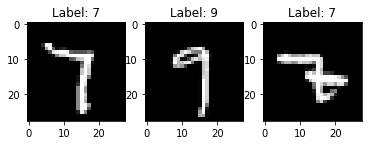

In [6]:
# load data
train_batch = 128
test_batch = 8192
train_data = datasets.MNIST("../data", train=True, download=True, transform=transforms.ToTensor())
test_data = datasets.MNIST("../data", train=False, transform=transforms.ToTensor())
train_loader = torch.utils.data.DataLoader(train_data, batch_size=train_batch, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_data, batch_size=test_batch, shuffle=True)

xs, labels = next(iter(test_loader))
plt.figure(figsize=(6,6))
for i in range(3):
    example = xs[i].view(28, -1)
    plt.subplot(1, 3, i+1)
    plt.imshow(example.data.numpy(), cmap='Greys_r')
    plt.title("Label: "+str(labels[i].item()))
plt.show()

The data looks like what we expected, so we next, I'll initialize the architecture and train it up using the above training loop. I'll start off with 25 epochs, since that should be enough for this simple example to converge to something, and I'll use a KL weighting factor of 1e-2, since I know from experience that we should be able to train a working model with this weighting on the KL-divergence error.

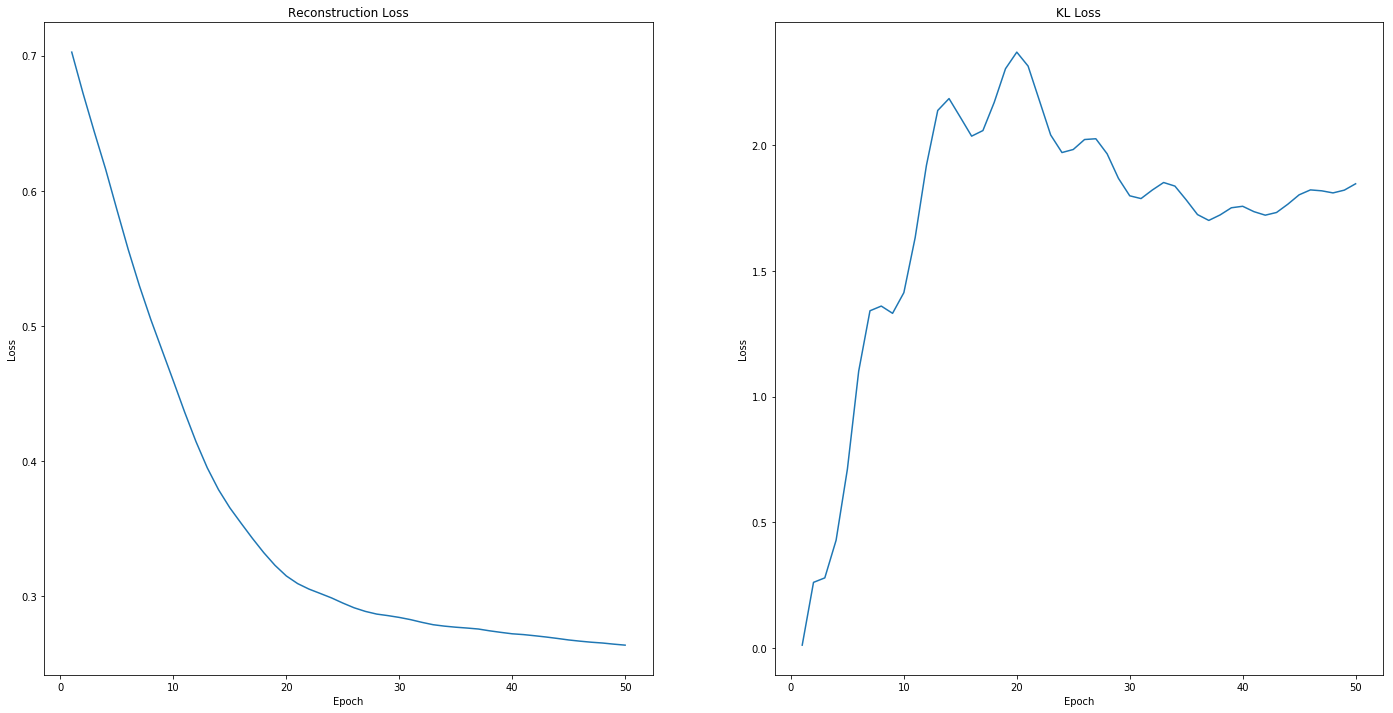

In [7]:
encoder = VAE_Encoder(784, 256, 2)
decoder = Decoder(2, 256, 784)
vae = VAE(encoder, decoder)
optim = torch.optim.Adam(vae.parameters())
train_model(vae, optim, epochs=50, kl_weighting=1e-2)

And it's trained! 

First off, we'll take a look at the reconstructed output of our autoencoder. We do this by calling our generate_samples() function, which samples at fixed intervals from $[0, 1]$, and then transforms this into a density on $p(z)$ using the inverse CDF function. We then pass those $z$ values through the decoder to reconstruct the image.

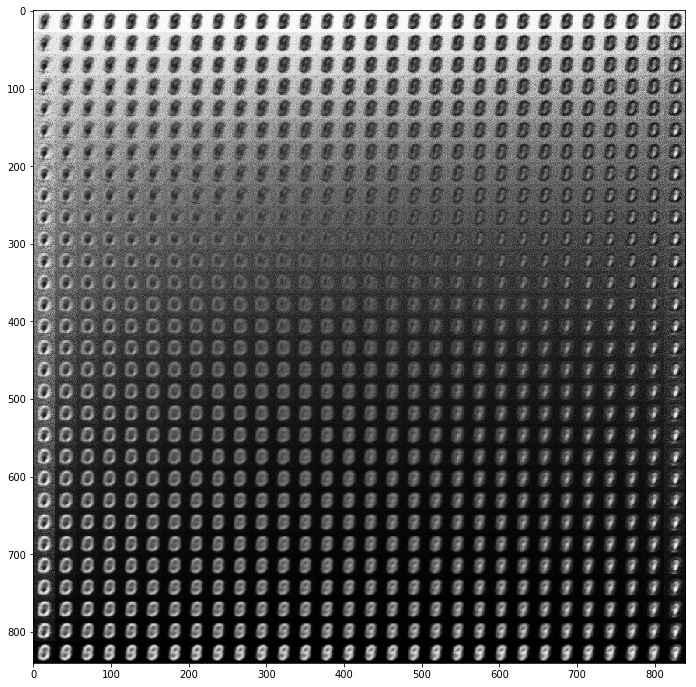

In [8]:
generate_samples(vae)

And we'll plot the clustering in the latent space to see how the values have been clustered.

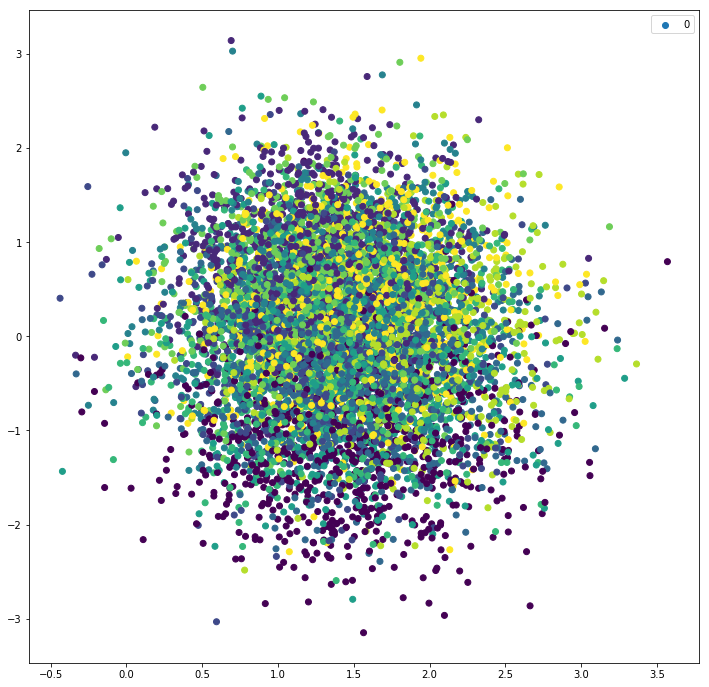

In [9]:
visualize_latent_space(vae)

That's not bad, though there are few interesting things to note.
1. Our KL Loss actually got worse over the course of training, which is strange!
2. Our data has a nice normal spread in the latent space, which is what we want.
3. 

and the results are consistent if you do it this way. That is, you can train it as many times as you like, and it should converge to something broadly similar to the above. However, what about our earlier claims about the failure modes of VAEs? To demonstrated the first point, I'll train the exact same architecture as above, except this time, I'm going to set the KL weighting factor to 1 and see what happens.

### 3.2 Varying the KL Weighting
This is exactly the same as the process above, so I'll keep the exposition short and sweet. First, I'll define a new model, and then in the cells below, I'll generate new samples, and plot the clustering in the latent space:

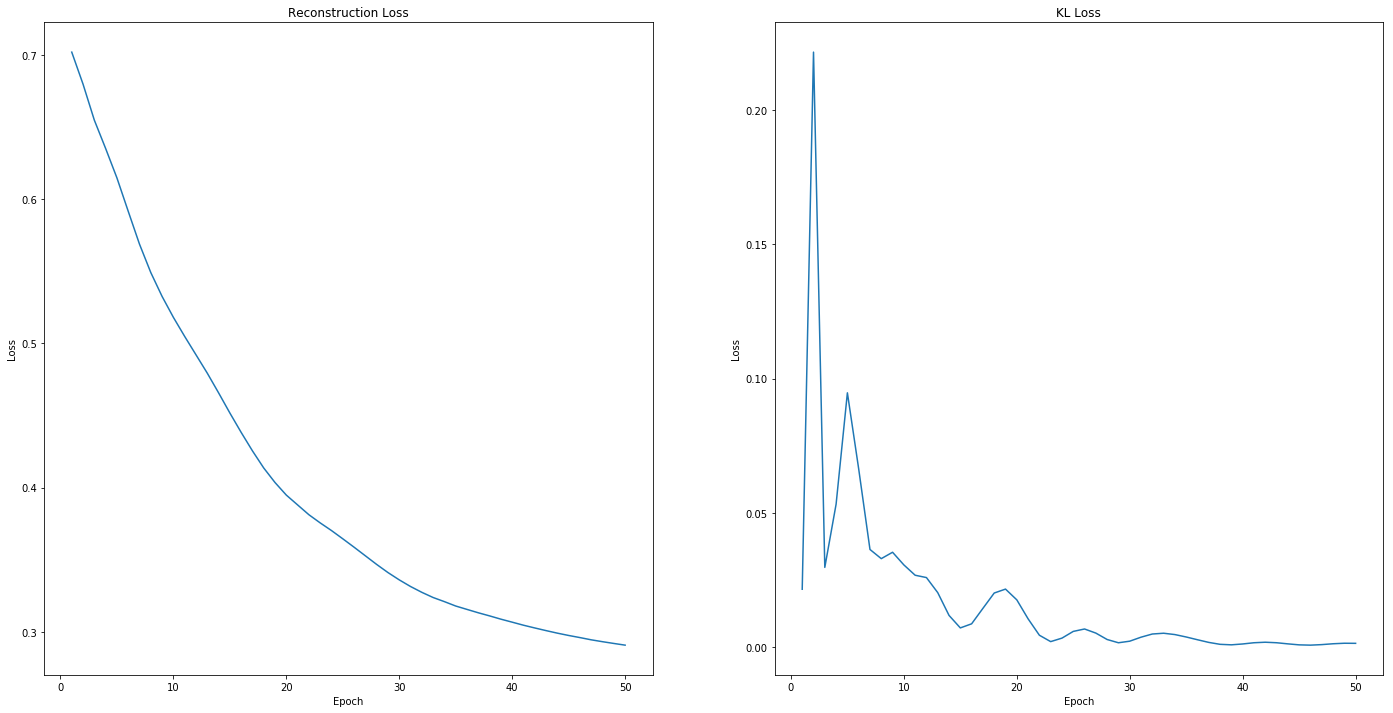

In [10]:
encoder_2 = VAE_Encoder(784, 256, 2)
decoder_2 = Decoder(2, 256, 784)
vae_2 = VAE(encoder_2, decoder_2)
optim_2 = torch.optim.Adam(vae_2.parameters())
train_model(vae_2, optim_2, epochs=50)

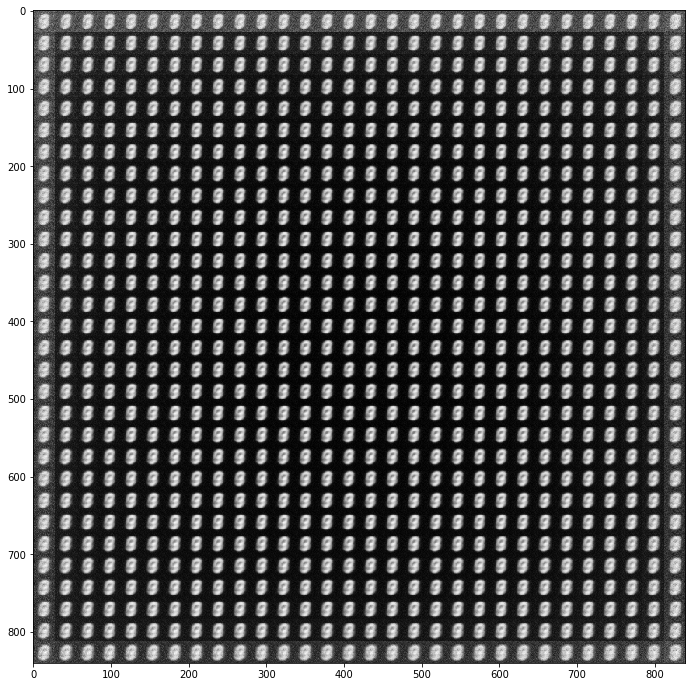

In [11]:
generate_samples(vae_2)

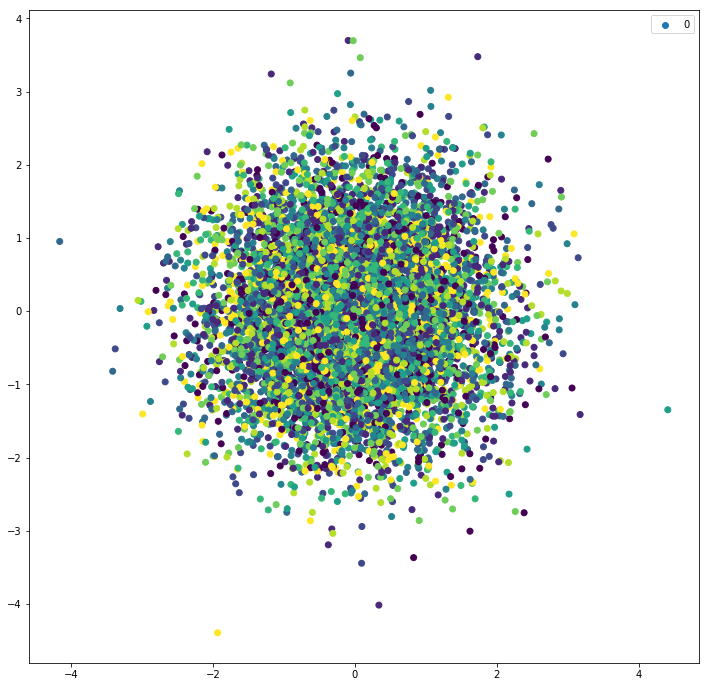

In [12]:
visualize_latent_space(vae_2)

As we can see, the KL-divergence error drops precipitously quick, and the model fails to learn a reconstruction of the input. Everything gets pushed towards $\mathbb{E}[z]=0$, which we can see in the latent space. Everything is normally distributed because forcing each individual $x_i$ to be normally distributed has the effect of forcing the latent space to be normally distributed, but the encodings are all stacked on top of one another. The decoder is unable to learn a meaningful reconstruction of the data from $z$, so it outputs an average that looks like a 0 or an 8.

This isn't exactly controversial -- it's well known that the VAE trades off between the KL loss and the reconstruction loss, and as mentioned previously, there's an entire literature based on solving this problem. But what about our second claim? What happens if we vary the batch size?

### 3.3 Varying the Batch Size
Here, I'll show that the performance of the encoder is also coupled to the batch size. I'll take the parameters that worked for us before, but this time, I'll dramatically increase the batch size of the training data. In theory, this should be beneficial, since it gives us a better approximation of the expected cost of our model (i.e. we should get a more accurate gradient estimate). In practice, however, the reconstruction suffers:

In [13]:
# load data
train_batch = 8192
test_batch = 8192
train_data = datasets.MNIST("../data", train=True, download=True, transform=transforms.ToTensor())
test_data = datasets.MNIST("../data", train=False, transform=transforms.ToTensor())
train_loader = torch.utils.data.DataLoader(train_data, batch_size=train_batch, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_data, batch_size=test_batch, shuffle=True)

Training our model

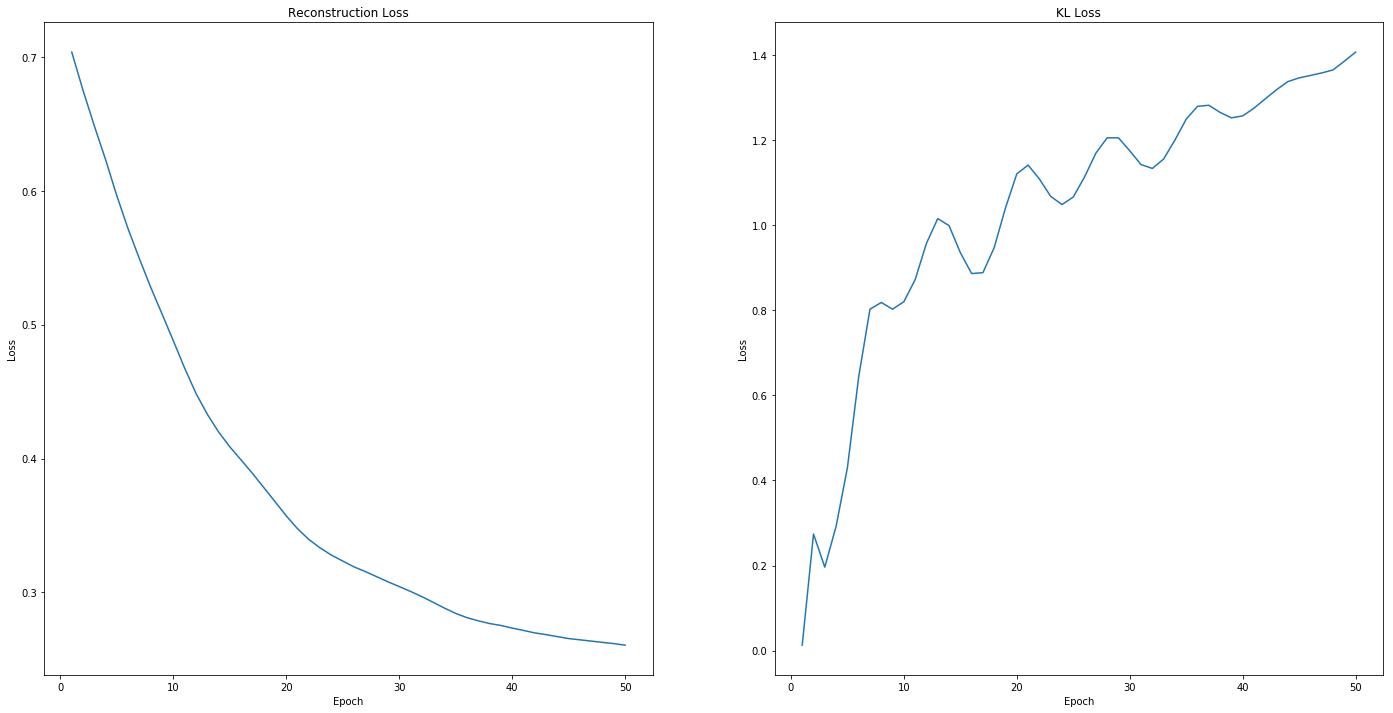

In [14]:
encoder_3 = VAE_Encoder(784, 256, 2)
decoder_3 = Decoder(2, 256, 784)
vae_3 = VAE(encoder_3, decoder_3)
optim_3 = torch.optim.Adam(vae_3.parameters())
train_model(vae_3, optim_3, epochs=50, kl_weighting=1e-2)

Now for the visuals:

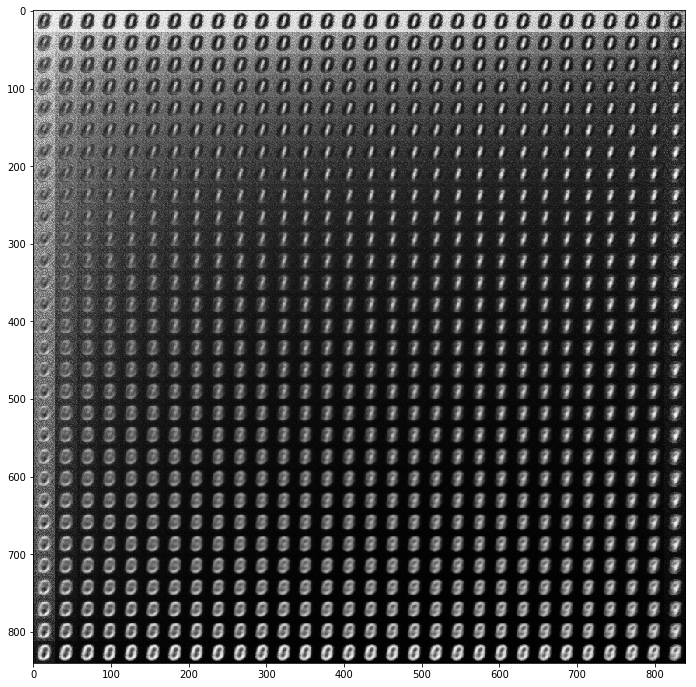

In [15]:
generate_samples(vae_3)

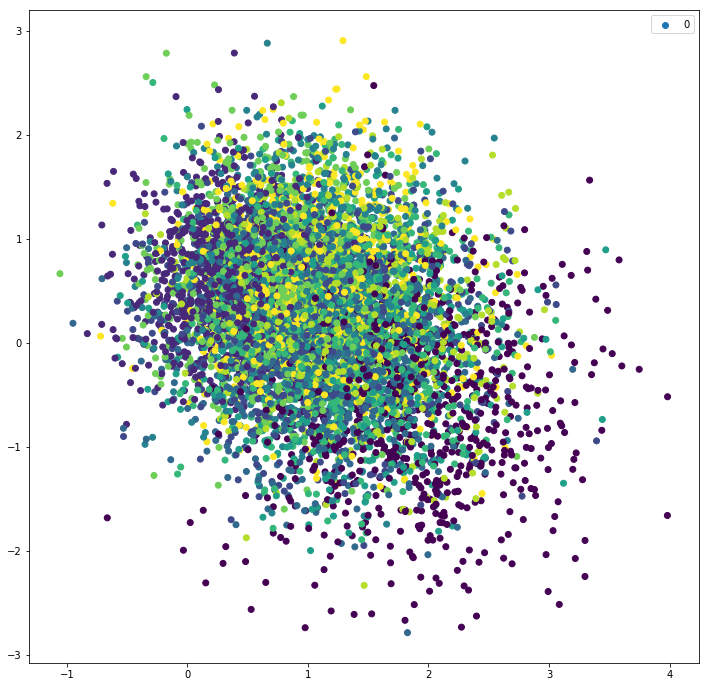

In [16]:
visualize_latent_space(vae_3)

As we can see, increasing the batch size has a detrimental effect on the model's ability to learn a decent reconstruction. Why is this the case? In all honesty, I'm not sure. My initial guess is that larger batches are somehow inducing averaging in the reconstruction. However, what I do know is that it's somewhat problematic, since it implies that each hyperparameter setting needs to tuned to take the other hyperparameters into account. That is, you need to find the winning combination, or your model performance will degrade (or in the worst case, just not work).

## 4. Modifying the Standard VAE
So I above I mentioned that instead of pushing each encoding $z_i|x_i$ to be normally distributed, we could also feed our batch in, find the distribution over $z$, and force *this* to be normally distributed, instead of each encoding. The first example lets us do away with the reparameterization trick entirely, though as I'll show later, we can combine the two ideas to keep stochasticity for the encodings. However, this idea implicitly assumes that we can sample a portion of $x$ and that this batch is roughly representative of $p(x)$. This isn't really problematic, since batch-based training methods make this assumption *anyway*, but for the sake of completeness, let's see if this assumption holds true. To start with, I'll plot histograms for the pixel activations of a number of examples for the same number to show that they're all drawn from the same distribution. Then, I'll feed them through an un-trained encoder (which I'll quickly define below) and see what the untrained latent space looks like.

So firstly, the encoder and the new model:

In [17]:
class Encoder(torch.nn.Module):
    """
        Encoder for our modified autoencoder. This time we don't need a mu and logvar, since
        we get those from the distribution over p(z|x).
    """
    def __init__(self, input_dim, hidden_dim, output_dim):
        super(Encoder,self).__init__()
        self.fc1 = torch.nn.Linear(input_dim, hidden_dim)
        self.output = torch.nn.Linear(hidden_dim, output_dim)
    
    def forward(self, x):
        x = F.tanh(self.fc1(x))
        return self.output(x)
    

class Autoencoder(VAE):
    """
        Modified VAE implementation. We don't use the reparameterization trick and instead
        find an encoder that maps all datapoints x_i onto an induced distribution p(z|x_i) 
        that we force to be N(0,I).
    """
    def __init__(self, encoder, decoder):
        super(Autoencoder, self).__init__(encoder, decoder)
    
    def encode(self, x):
        zs = self.encoder(x)
        mu = zs.mean(dim=0, keepdim=True) # finding the mean of p(z)
        sigma = zs.std(dim=0, keepdim=True) # finding the sigma of p(z)
        return zs, mu, torch.log(sigma.pow(2))

This is pretty straightforward -- basically a standard autoencoder. As we can see, the only change is that our z values are no longer sampled, and that we calculate mu and std over the latent variables rather than having them be outputs of the encoder.

Next, I'll plot the pixel activations, and the encodings:

In [49]:
_0 = []
_1 = []
_2 = []
_3 = []
_4 = []
_5 = []
_6 = []
_7 = []
_8 = []
_9 = []

samples = 50
running = True
while running:
    xs, labels = next(iter(test_loader))
    for x, l in zip(xs, labels):
        if str(l.item()) == "0" and len(_0) < samples: _0.append(x)
        if str(l.item()) == "1" and len(_1) < samples: _1.append(x)
        if str(l.item()) == "2" and len(_2) < samples: _2.append(x)
        if str(l.item()) == "3" and len(_3) < samples: _3.append(x)
        if str(l.item()) == "4" and len(_4) < samples: _4.append(x)
        if str(l.item()) == "5" and len(_5) < samples: _5.append(x)
        if str(l.item()) == "6" and len(_6) < samples: _6.append(x)
        if str(l.item()) == "7" and len(_7) < samples: _7.append(x)
        if str(l.item()) == "8" and len(_8) < samples: _8.append(x)
        if str(l.item()) == "9" and len(_9) < samples: _9.append(x)
    
    if (len(_0) == samples) and (len(_1) == samples) and (len(_2) == samples) and \
        (len(_3) == samples) and (len(_4) == samples) and (len(_5) == samples) and \
        (len(_6) == samples) and (len(_7) == samples) and (len(_8) == samples) and \
        (len(_9) == samples):
        running = False

# we'll see what our encodings looks like in a 1D latent space
modified_encoder = Encoder(784, 256, 1)
z_0 = modified_encoder(torch.Tensor(_0).to(device))
z_1 = modified_encoder(torch.Tensor(_1).to(device))
z_2 = modified_encoder(torch.Tensor(_2).to(device))
z_3 = modified_encoder(torch.Tensor(_3).to(device))
z_4 = modified_encoder(torch.Tensor(_4).to(device))
z_5 = modified_encoder(torch.Tensor(_5).to(device))
z_6 = modified_encoder(torch.Tensor(_6).to(device))
z_7 = modified_encoder(torch.Tensor(_7).to(device))
z_8 = modified_encoder(torch.Tensor(_8).to(device))
z_9 = modified_encoder(torch.Tensor(_9).to(device))

plt.figure(figsize=(24,12))
plt.subplots(2,1,1)
plt.hist(_0, bins=100, density=True)
plt.hist(_1, bins=100, density=True)
plt.hist(_2, bins=100, density=True)
plt.hist(_3, bins=100, density=True)
plt.hist(_4, bins=100, density=True)
plt.hist(_5, bins=100, density=True)
plt.hist(_6, bins=100, density=True)
plt.hist(_7, bins=100, density=True)
plt.hist(_8, bins=100, density=True)
plt.hist(_9, bins=100, density=True)
plt.title("Pixel Activation Histogram")
plt.xlabel("Downsampled Pixel")
plt.ylabel("Density")
plt.legend(["0", "1", "2", "3", "4", "5", "6", "7", "8", "9"])

plt.subplots(2,1,2)
plt.hist(z_0, bins=100, density=True)
plt.hist(z_1, bins=100, density=True)
plt.hist(z_2, bins=100, density=True)
plt.hist(z_3, bins=100, density=True)
plt.hist(z_4, bins=100, density=True)
plt.hist(z_5, bins=100, density=True)
plt.hist(z_6, bins=100, density=True)
plt.hist(z_7, bins=100, density=True)
plt.hist(z_8, bins=100, density=True)
plt.hist(z_9, bins=100, density=True)
plt.title("1D Latent Space Mapping")
plt.xlabel("Encoding Value")
plt.ylabel("Density")
plt.legend(["0", "1", "2", "3", "4", "5", "6", "7", "8", "9"])
plt.show()

ValueError: only one element tensors can be converted to Python scalars

The first image is more or less what we would expect. It's trivially apparent that we can think of the image as a 2D heatmap of pixel activations, and plotting it in 1D like this shows a fairly consistent patter in the inputs that is distinct for each number. Furthermore, we can see that these differences are preserved in the latent space -- our network isn't mapping $2$s and $6$s to the same encodings, for example, though intuitively, some numbers are closer to one another than others. It now remains to be seen if we can learn a function $f_\theta : \mathcal{X}\rightarrow \mathcal{Z}$ such that $z\in \mathcal{Z} \sim \mathcal{N}(0,\mathbb{I})$:

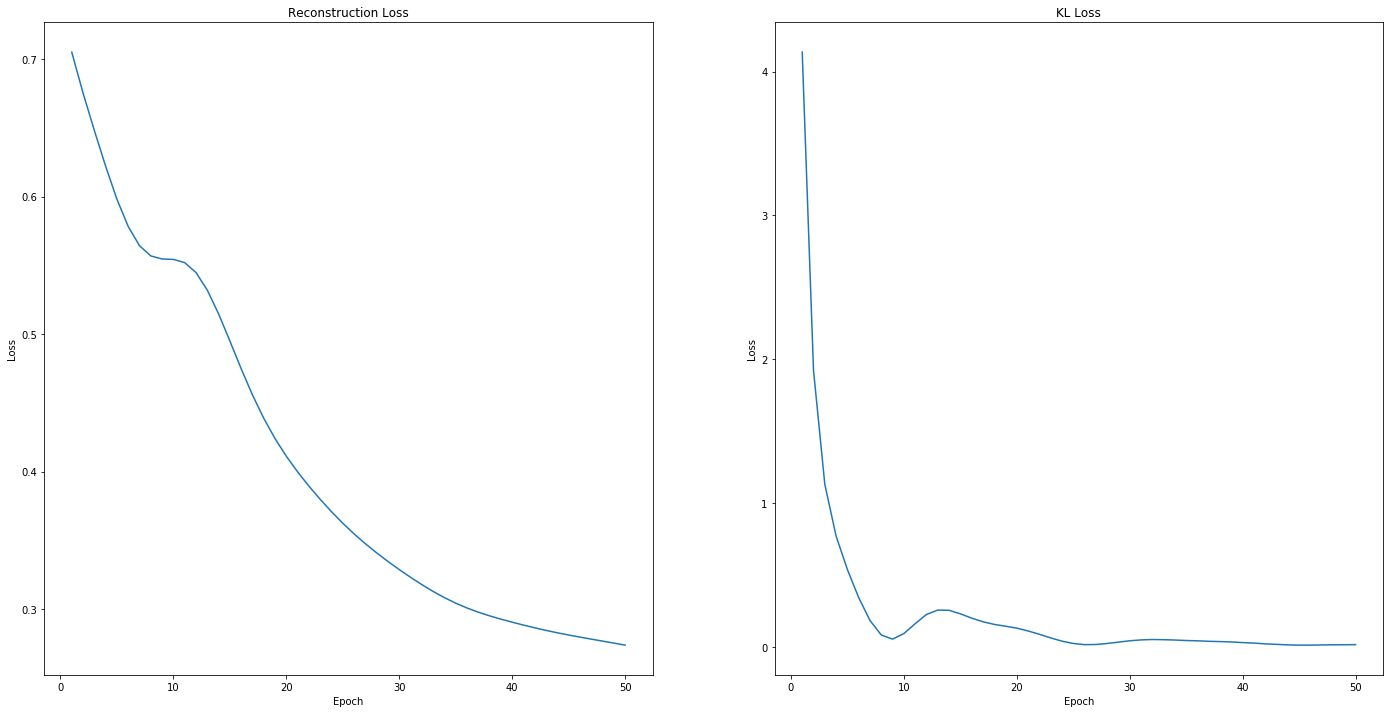

In [18]:
# load data
train_batch = 128
test_batch = 8192
train_data = datasets.MNIST("../data", train=True, download=True, transform=transforms.ToTensor())
test_data = datasets.MNIST("../data", train=False, transform=transforms.ToTensor())
train_loader = torch.utils.data.DataLoader(train_data, batch_size=train_batch, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_data, batch_size=test_batch, shuffle=True)

modified_encoder = Encoder(784, 256, 2)
modified_decoder = Decoder(2, 256, 784)
modified_vae = Autoencoder(modified_encoder, modified_decoder)
modified_optim = torch.optim.Adam(modified_vae.parameters())
train_model(modified_vae, modified_optim, epochs=50)

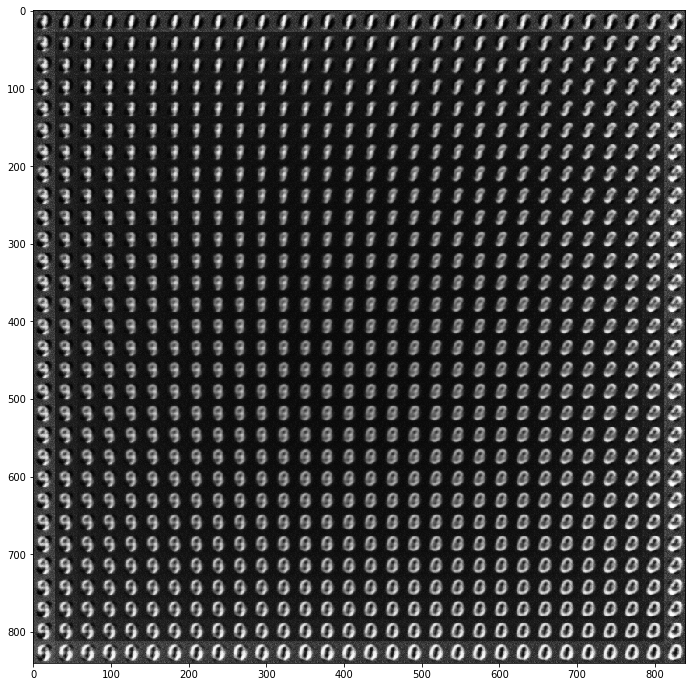

In [19]:
generate_samples(modified_vae)

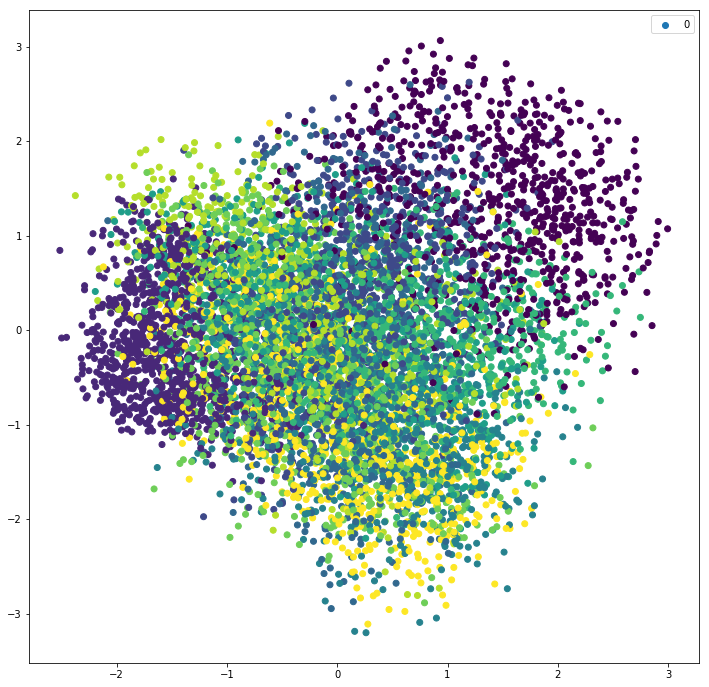

In [20]:
visualize_latent_space(modified_vae)

So I guess the first thing to notice is that unlike the standard VAE where the KL loss sometimes increases as the model learns a better reconstruction, in this case, both loss terms decrease at the same time. That is, the model is doing its best to minimize both objectives simultaneously, and they aren't trading off against one another.

The next thing to notice is that our model does indeed compress our encodings onto a unit Gaussian, and we can generate new samples by sampling from the latent space. Qualitatively, there doesn't seem to be a huge difference between the examples generated by this method compared to the standard variational autoencoder, though it's possible that this changes for more complicated datasets.

Interestingly, our latent space clustering is more separated, similar to what a standard autoencoder would produce. This is likely a result of the KL loss being a relatively small term compared to the reconstruction loss, since the KL loss is the component that forces the clustering onto the unit Gaussian.

So let's try a few things. Firstly we'll increase the batch size to see how our model fares compared to the VAE earlier. We should expect that as the batch size increases, the more representative it is of the data distribution, and the better the gradient estimate (i.e. our model will train faster). Secondly, we'll increase the KL loss, and see what effect this has on the latent space and the reconstruction. Finally, we'll use a more expressive model for the encoder and decoder and see how this does when we combine it with the larger KL loss term.

### 4.1 Increasing Batch Size

In [21]:
# load data
train_batch = 8192
test_batch = 8192
train_data = datasets.MNIST("../data", train=True, download=True, transform=transforms.ToTensor())
test_data = datasets.MNIST("../data", train=False, transform=transforms.ToTensor())
train_loader = torch.utils.data.DataLoader(train_data, batch_size=train_batch, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_data, batch_size=test_batch, shuffle=True)

modified_encoder_2 = Encoder(784, 256, 2)
modified_decoder_2 = Decoder(2, 256, 784)
modified_vae_2 = Autoencoder(modified_encoder_2, modified_decoder_2)
modified_optim_2 = torch.optim.Adam(modified_vae_2.parameters())
train_model(modified_vae_2, modified_optim_2, epochs=50)

KeyboardInterrupt: 

In [ ]:
generate_samples(modified_vae_2)

In [ ]:
visualize_latent_space(modified_vae_2)

### 4.2 Increasing KL Loss Weighting

In [ ]:
# load data
train_batch = 128
test_batch = 8192
train_data = datasets.MNIST("../data", train=True, download=True, transform=transforms.ToTensor())
test_data = datasets.MNIST("../data", train=False, transform=transforms.ToTensor())
train_loader = torch.utils.data.DataLoader(train_data, batch_size=train_batch, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_data, batch_size=test_batch, shuffle=True)

modified_encoder_3 = Encoder(784, 256, 2)
modified_decoder_3 = Decoder(2, 256, 784)
modified_vae_3 = Autoencoder(modified_encoder_3, modified_decoder_3)
modified_optim_3 = torch.optim.Adam(modified_vae_3.parameters())
train_model(modified_vae_3, modified_optim_3, epochs=50, kl_weighting=5)

In [ ]:
generate_samples(modified_vae_3)

In [ ]:
visualize_latent_space(modified_vae_3)

As we can see, the model still manages to learn even when we increase the KL loss five-fold.

### 4.3 Using a More Expressive Architecture

In [ ]:
class BiggerEncoder(torch.nn.Module):
    """
        Encoder for our modified autoencoder. This time we don't need a mu and logvar, since
        we get those from the distribution over p(z|x).
    """
    def __init__(self, input_dim, hidden_dim, output_dim):
        super(BiggerEncoder, self).__init__()
        self.fc1 = torch.nn.Linear(input_dim, hidden_dim)
        self.fc2 = torch.nn.Linear(hidden_dim, hidden_dim)
        self.output = torch.nn.Linear(hidden_dim, output_dim)
    
    def forward(self, x):
        x = F.tanh(self.fc1(x))
        x = F.tanh(self.fc2(x))
        return self.output(x)

    
class BiggerDecoder(torch.nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim):
        super(BiggerDecoder, self).__init__()
        self.fc1 = torch.nn.Linear(input_dim, hidden_dim)
        self.fc2 = torch.nn.Linear(hidden_dim, hidden_dim)
        self.output = torch.nn.Linear(hidden_dim, output_dim)
    
    def forward(self, x):
        x = F.tanh(self.fc1(x))
        x = F.tanh(self.fc2(x))
        return F.sigmoid(self.output(x))

In [ ]:
modified_encoder_4 = BiggerEncoder(784, 512, 2)
modified_decoder_4 = BiggerDecoder(2, 512, 784)
modified_vae_4 = Autoencoder(modified_encoder_4, modified_decoder_4)
modified_optim_4 = torch.optim.Adam(modified_vae_4.parameters())
train_model(modified_vae_4, modified_optim_4, epochs=50)

In [ ]:
generate_samples(modified_vae_4)

In [ ]:
visualize_latent_space(modified_vae_4)

Whoa, that's not what I expected! The more expressive architecture learned to cluster the values in four distint populations. Interestingly, some of the numbers appear in more than one population group. Furthermore, there are some clear similarities between this clustering, and the one we got in Section 4.1, almost like that architecture was trying to learn this clustering, but wasn't expressive enough. What happens if we increase the batch size substantially?

In [ ]:
# load data
train_batch = 8192
test_batch = 8192
train_data = datasets.MNIST("../data", train=True, download=True, transform=transforms.ToTensor())
test_data = datasets.MNIST("../data", train=False, transform=transforms.ToTensor())
train_loader = torch.utils.data.DataLoader(train_data, batch_size=train_batch, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_data, batch_size=test_batch, shuffle=True)

modified_encoder_5 = BiggerEncoder(784, 1024, 2)
modified_decoder_5 = BiggerDecoder(2, 1024, 784)
modified_vae_5 = Autoencoder(modified_encoder_5, modified_decoder_5)
modified_optim_5 = torch.optim.Adam(modified_vae_5.parameters())
train_model(modified_vae_5, modified_optim_5, epochs=50)

In [ ]:
generate_samples(modified_vae_5)

In [ ]:
visualize_latent_space(modified_vae_5)

As we would expect, a more expressive model gives us a better mapping onto the unit normal, whilst still keeping all of the classes distinct.

The weakness of this method is that the mapping from x to z is deterministic, but as I mentioned previously, we can combine the ideas underlying the two different autoencoders together into a single network. This way, we can get both a mean and standard deviation for the encodings, using the same reparameterization trick as the standard VAE to train the network. The next section goes through this.

## 5. One Step Further
So the idea here is that we still want our encodings to be stochastic in the latent space, but we want to avoid the problems we had earlier with the standard VAE by incorporating the ideas from above. Thankfully, this is fairly simple. We can just combine the distributions into single distribution using the formulas:

$\mu = \frac{\sum_i n_i\mu_i}{\sum_j n_j}$

$\sigma^2 = \frac{\sum_i n_i \sigma_i^2 + \left(\sum_j n_j \mu_j\right)^2}{\left(\sum_k n_k\right)^2} - \mu$

This done in the new encoder below:

In [90]:
class ModifiedVAE(VAE):
    def __init__(self, encoder, decoder):
        super(ModifiedVAE, self).__init__(encoder, decoder)
    
    def encode(self, x):
        mus, logvars = self.encoder(x)
        var = logvars.exp()
        sigmas = var.sqrt()
        eps = torch.randn(logvars.size())
        zs = mus + sigmas * eps
        mu_ = torch.mean(mus, dim=0, keepdim=True)
        vars_ = (torch.sum(var, dim=0, keepdim=True) + torch.sum(mu_, dim=0, keepdim=True)**2) / var.size(0)**2 - mu_
        logvars_ = torch.log(vars_)
        print(logvars_.size())
        print(logvars_)
        return zs, mu_, logvars_

We'll now train our model and visualize things as before, but we'll also visualize samples around a *single* datapoint as well:

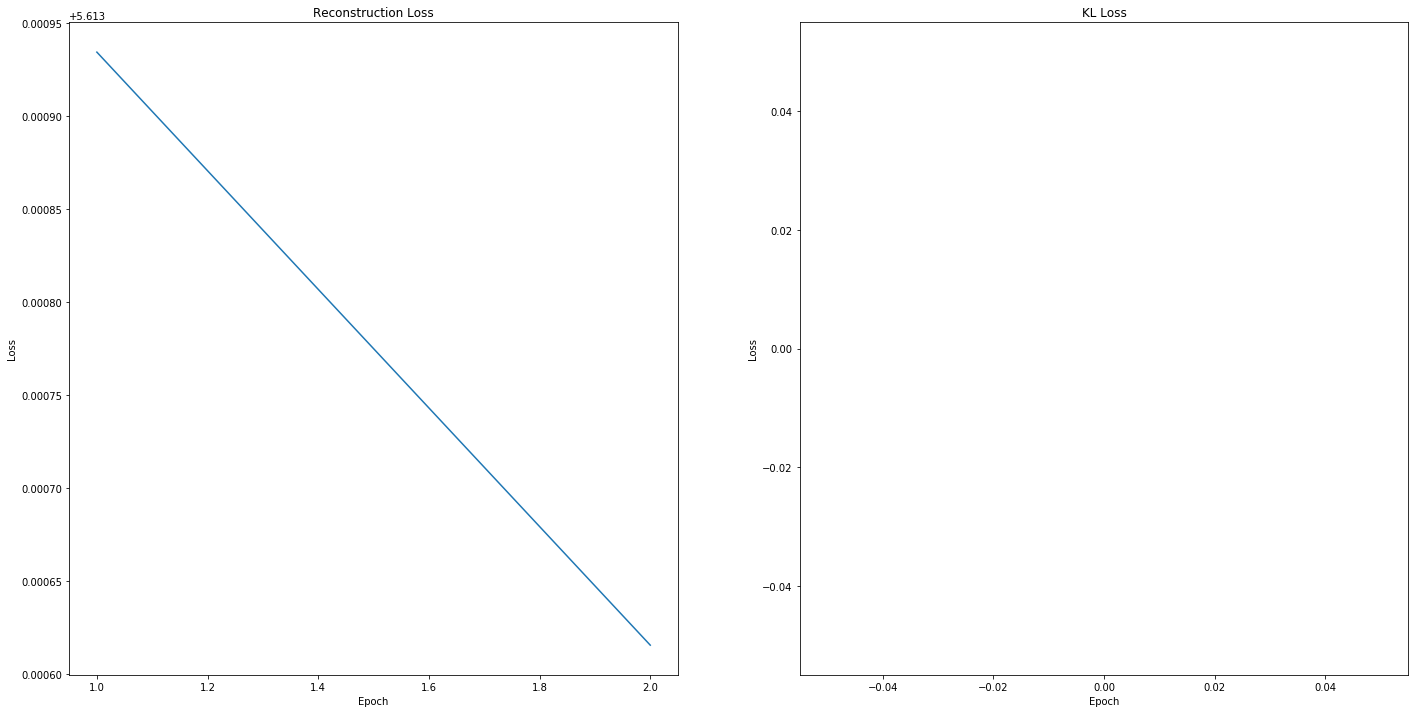

torch.Size([1, 2])
tensor([[nan., nan.]])
torch.Size([1, 2])
tensor([[nan., nan.]])
torch.Size([1, 2])
tensor([[nan., nan.]])


In [ ]:
final_encoder = VAE_Encoder(784, 256, 2)
final_decoder = Decoder(2, 256, 784)
final_vae = ModifiedVAE(final_encoder, final_decoder)
final_optim = torch.optim.Adam(modified_vae.parameters())
train_model(final_vae, final_optim, epochs=25)

In [ ]:
generate_samples(final_vae)

In [ ]:
visualize_latent_space(final_vae)

And visualizing encodings around a single datapoint:

In [ ]:
xs, labels = next(iter(test_loader))
mu, logvar = final_encoder(xs[0])
sigmas = logvar.exp().sqrt()
digit_size = 28
figure = np.zeros((digit_size * n, digit_size * n))
norm.ppf(0.95, loc=10, scale=2)
x_points = norm.ppf(np.linspace(0.001,0.999, n), loc=mus[0].numpy(), scale=sigmas[0].numpy())
y_points = norm.ppf(np.linspace(0.001,0.999, n), loc=mus[1].numpy(), scale=sigmas[1].numpy())
for i, xi in enumerate(x_points):
    for j, yi in enumerate(y_points):
        z_sample = torch.from_numpy(np.array([xi, yi])).float()
        x_decoded = model.decode(z_sample)
        digit = x_decoded.data.view(-1,28).numpy()
        figure[i * digit_size:(i + 1) * digit_size, j * digit_size:(j + 1) * digit_size] = digit
plt.figure(figsize=(12,12))
plt.imshow(figure, cmap='Greys_r')
plt.show()

As we can see, we can still use this idea to sample around the datapoint and see what other examples are close by. Naturally, these are all fairly close to the original, though there is some variation at the edges. Since our loss function is effectively the same as for the previous autoencoder, we should expect the behavior to be broadly the same for different KL loss weightings and batch sizes (indeed, we trained this one using the same KL loss weighting as for the previous model).

## 6. Conclusions
As I mentioned above, this is mostly a learning experience for me. For one thing, it seems to me that the logic underlying the ELBO should also hold here, except we're no longer reducing KL divergence between distributions given by datapoints, but over the whole dataset. If I'm wrong, or this method breaks down in other ways, I'm sure others will let me know! In any case, I hope that the exposition has been clear, and the examples illustrative of the point that I'm trying to make.